<a href="https://colab.research.google.com/github/GiulioCMSanto/HDSIdent/blob/master/notebooks/MIMO%20Systems/Segmentation/numerical_conditioning_mimo_laguerre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numerical Conditioning: MIMO Laguerre Approach

[HDSIdent: Historical Data Segmentation for System Identification](https://github.com/GiulioCMSanto/HDSIdent)

This notebook explores how to obtain intervals suitable for system identification through a numerical conditioning Laguerre Filter approach, considering multivariable systems.


**NOTICE: this notebook, as well as the related dataset, is part of my masters dissertation, which was not yet published. Therefore, referencing is not permited until the work is available.**


_**Related works**_:

```
PERETZKI, D. et al. Data mining of historic data for process identification.
In: Proceedings of the 2011 AIChE Annual Meeting, p. 1027–1033, 2011.

SHARDT, Y. A. W.; SHAH, S. L. Segmentation Methods for Model Identification from
Historical Process Data. In: Proceedings of the 19th World Congress.
Cape Town, South Africa: IFAC, 2014. p. 2836–2841.

BITTENCOURT, A. C. et al. An algorithm for finding process identification
intervals from normal operating data. Processes, v. 3, p. 357–383, 2015.

PATEL, A. Data Mining of Process Data in Mutlivariable Systems.
Degree project in electrical engineering — Royal Institute of Technology,
Stockholm, Sweden, 2016.

ARENGAS, D.; KROLL, A. A Search Method for Selecting Informative Data in Predominantly
Stationary Historical Records for Multivariable System Identification.
In: Proceedings of the 21st International Conference on System Theory,
Control and Computing (ICSTCC). Sinaia, Romenia: IEEE, 2017a. p. 100–105.

ARENGAS, D.; KROLL, A. Searching for informative intervals in predominantly stationary
data records to support system identification. In: Proceedings of the XXVI International
Conference on Information, Communication and Automation Technologies (ICAT). Sarajevo,
Bosnia-Herzegovina: IEEE, 2017b.
```




In [ ]:
!git clone https://github.com/GiulioCMSanto/HDSIdent.git

fatal: destination path 'HDSIdent' already exists and is not an empty directory.


In [ ]:
# Change into the directory for install
%cd HDSIdent/

[Errno 2] No such file or directory: 'HDSIdent/!python setup.py install'
/content/HDSIdent


In [ ]:
!python setup.py install

running install
running bdist_egg
running egg_info
writing HDSIdent.egg-info/PKG-INFO
writing dependency_links to HDSIdent.egg-info/dependency_links.txt
writing requirements to HDSIdent.egg-info/requires.txt
writing top-level names to HDSIdent.egg-info/top_level.txt
writing manifest file 'HDSIdent.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/HDSIdent
copying build/lib/HDSIdent/__init__.py -> build/bdist.linux-x86_64/egg/HDSIdent
byte-compiling build/bdist.linux-x86_64/egg/HDSIdent/__init__.py to __init__.cpython-36.pyc
creating build/bdist.linux-x86_64/egg/EGG-INFO
copying HDSIdent.egg-info/PKG-INFO -> build/bdist.linux-x86_64/egg/EGG-INFO
copying HDSIdent.egg-info/SOURCES.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying HDSIdent.egg-info/dependency_links.txt -> build/bdist.linux-x86_64/egg/EGG-INFO
copying HDSIdent.egg-info/requires.txt 

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

import plotly
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode

plotly.io.renderers.default = 'colab'

%matplotlib inline
sns.set_style('darkgrid')

In [ ]:
from HDSIdent.data_treatment.data_preprocessing import Preprocessing
from HDSIdent.initial_intervals.exponentially_weighted import ExponentiallyWeighted
from HDSIdent.initial_intervals.bandpass_filter import BandpassFilter
from HDSIdent.initial_intervals.sliding_window import SlidingWindow

from HDSIdent.segmentation_methods.mimo_segmentation import MIMOSegmentation
from HDSIdent.model_structures.ar_structure import ARStructure
from HDSIdent.model_structures.arx_structure import ARXStructure
from HDSIdent.model_structures.laguerre_filter import LaguerreStructure

## **1. Read Data**

In [ ]:
u1_url = "https://raw.githubusercontent.com/GiulioCMSanto/HDSIdent/master/data/distillation_column/mimo_simu_u1.csv"
u2_url = "https://raw.githubusercontent.com/GiulioCMSanto/HDSIdent/master/data/distillation_column/mimo_simu_u2.csv"
y1_url = "https://raw.githubusercontent.com/GiulioCMSanto/HDSIdent/master/data/distillation_column/mimo_simu_y1.csv"
y2_url = "https://raw.githubusercontent.com/GiulioCMSanto/HDSIdent/master/data/distillation_column/mimo_simu_y2.csv"

In [ ]:
u1 = pd.read_csv(u1_url, error_bad_lines=False, header=None)
u2 = pd.read_csv(u2_url, error_bad_lines=False, header=None)
y1 = pd.read_csv(y1_url, error_bad_lines=False, header=None)
y2 = pd.read_csv(y2_url, error_bad_lines=False, header=None)

## **2. Data Preprocessing**

In [ ]:
pp = Preprocessing(
        scaler='MinMaxScaler',
        feature_range=(-0.5,0.5),
        k=100);

In [ ]:
X_clean, Y_clean = pp.fit_transform(X=np.concatenate([u1,u2],axis=1),
                                    y=np.concatenate([y1,y2],axis=1))

## **3. Define Potential Intervals - Exponentially Weighted Moving Average (EWMA) Filter**

In [ ]:
df = pd.DataFrame()
df['U1'] = np.squeeze(X_clean[:,0])
df['U2'] = np.squeeze(X_clean[:,1])
df['Y1'] = np.squeeze(Y_clean[:,0])
df['Y2'] = np.squeeze(Y_clean[:,1])

In [ ]:
EW = ExponentiallyWeighted(
        forgetting_fact_v = np.array([0.006,0.006,0.006,0.006]),
        forgetting_fact_u = np.array([0.006,0.006,0.006,0.006]),
        H_v = [0.005,0.005,0.005,0.005],
        num_previous_indexes=50,
        verbose=0,
        n_jobs=-1);

EW.fit(X=df[['U1','U2']], y=df[['Y1','Y2']]);

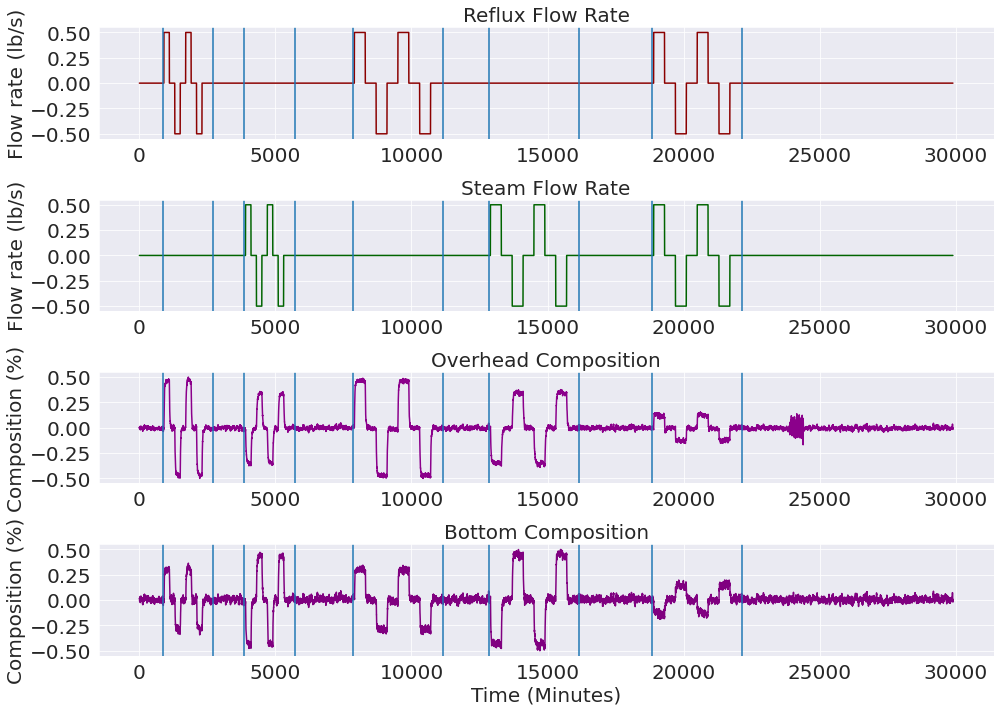

In [ ]:
plt.figure(figsize=(14,10));

plt.subplot(4,1,1);
plt.plot(X_clean[:,0], color='darkred');
plt.title("Reflux Flow Rate", fontsize=20);
plt.ylabel("Flow rate (lb/s)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
for key, interval in EW.unified_intervals.items():
    plt.axvline(np.min(interval))
    plt.axvline(np.max(interval))
    
plt.subplot(4,1,2);
plt.plot(X_clean[:,1], color='darkgreen');
plt.title("Steam Flow Rate", fontsize=20);
plt.ylabel("Flow rate (lb/s)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
for key, interval in EW.unified_intervals.items():
    plt.axvline(np.min(interval))
    plt.axvline(np.max(interval))
    
plt.subplot(4,1,3);
plt.plot(Y_clean[:,0], color='darkmagenta');
plt.title("Overhead Composition", fontsize=20);
plt.ylabel("Composition (%)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
for key, interval in EW.unified_intervals.items():
    plt.axvline(np.min(interval))
    plt.axvline(np.max(interval))
    
plt.subplot(4,1,4);
plt.plot(Y_clean[:,1],  color='purple');
plt.title("Bottom Composition", fontsize=20);
plt.ylabel("Composition (%)", fontsize=20);
plt.xlabel("Time (Minutes)", fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
for key, interval in EW.unified_intervals.items():
    plt.axvline(np.min(interval))
    plt.axvline(np.max(interval))
    
plt.tight_layout();

## **4. Apply Laguere Filter Method**

In [ ]:
LG = LaguerreStructure(
        Nb=10,
        p=0.92,
        delay=10,
        cc_alpha=0.05,
        initial_intervals=EW.unified_intervals,
        efr_type='type_2',
        sv_thr=0.5,
        n_jobs = -1,
        verbose = 0
        )

In [ ]:
start = time()
LG.fit(X=df[['U1','U2']],
       y=df[['Y1','Y2']]);
end = time()

In [ ]:
print("Execution Time: {}".format(end-start))

Execution Time: 27.226277828216553


In [ ]:
pd.DataFrame(LG.miso_ranks).T

,Y2,Y1
segment_0,"{'U1': 9, 'U2': 0}","{'U1': 9, 'U2': 0}"
segment_1,"{'U1': 0, 'U2': 9}","{'U1': 0, 'U2': 9}"
segment_2,"{'U1': 9, 'U2': 0}","{'U1': 9, 'U2': 0}"
segment_3,"{'U1': 0, 'U2': 9}","{'U1': 0, 'U2': 9}"
segment_4,"{'U1': 9, 'U2': 9}","{'U1': 9, 'U2': 9}"


In [ ]:
pd.DataFrame(LG.cond_num_dict).T

,Y2,Y1
segment_0,"{'U1': 3826.706031967569, 'U2': inf}","{'U1': 3826.706031967569, 'U2': inf}"
segment_1,"{'U1': inf, 'U2': 3826.706031967569}","{'U1': inf, 'U2': 3826.706031967569}"
segment_2,"{'U1': 9959.914853799299, 'U2': inf}","{'U1': 9959.914853799299, 'U2': inf}"
segment_3,"{'U1': inf, 'U2': 9959.914853811855}","{'U1': inf, 'U2': 9959.914853811855}"
segment_4,"{'U1': 9959.914853811855, 'U2': 9959.914853811...","{'U1': 9959.914853811855, 'U2': 9959.914853811..."


In [ ]:
pd.DataFrame(LG.chi_squared_dict).T

,Y2,Y1
segment_0,"{'U1': 378.2632857298497, 'U2': 0.138210135715...","{'U1': 963.9613150224066, 'U2': 0.056399286907..."
segment_1,"{'U1': 0.20017666139654594, 'U2': 592.70861826...","{'U1': 0.2569120889195506, 'U2': 678.928210071..."
segment_2,"{'U1': 584.3279675117058, 'U2': 0.718393858043...","{'U1': 1465.3879988959957, 'U2': 0.20851096560..."
segment_3,"{'U1': 0.13136012639661815, 'U2': 794.32705879...","{'U1': 0.13428797326329686, 'U2': 1036.1017887..."
segment_4,"{'U1': 246.35075531972493, 'U2': 246.350755319...","{'U1': 377.3375928186257, 'U2': 377.3375928186..."


In [ ]:
pd.DataFrame(LG.miso_correlations).T

,Y2,Y1
segment_0,"{'U1': 6.049553079452166, 'U2': 0}","{'U1': 6.1855924420060315, 'U2': 0}"
segment_1,"{'U1': 0, 'U2': 6.138044004357165}","{'U1': 0, 'U2': 6.02462199491633}"
segment_2,"{'U1': 6.3674995781024215, 'U2': 0}","{'U1': 6.444531168813707, 'U2': 0}"
segment_3,"{'U1': 0, 'U2': 6.40566838006142}","{'U1': 0, 'U2': 6.355851475623052}"
segment_4,"{'U1': 6.321571117895862, 'U2': 6.321571117895...","{'U1': 6.468561375622979, 'U2': 6.468561375622..."


### **4.1 Case 1: at least one input-output pair must satisfy the required criteria**

In [ ]:
MS_1 = MIMOSegmentation(
          model_structure=[LG],
          segmentation_method=['method1'],
          parameters_dict={'Laguerre':{'chi2_p_value_thr':0.01, 
                                        'cond_thr':15000, 
                                        'min_input_coupling':1,
                                        'min_output_coupling':1}
                            },
          segmentation_type='stationary',
          n_jobs=-1,
          verbose=1);

In [ ]:
MS_1.fit(X=df[['U1','U2']],
         y=df[['Y1','Y2']]);

Fitting Laguerre Model Structure...
Laguerre Structure fit finished! 


Beginning Stationary Segmentation for method1...
Stationary Segmentation Finished! 




[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [ ]:
print("Approved Intervals: {}".format(
MS_1.sucessed_intervals['method1']['Laguerre'].keys()))

Approved Intervals: dict_keys(['segment_0', 'segment_1', 'segment_3', 'segment_2', 'segment_4'])


### **4.2 Case 2: all inputs and all outputs must satisfy the required criteria**

In [ ]:
MS_2 = MIMOSegmentation(
          model_structure=[LG],
          segmentation_method=['method1'],
          parameters_dict={'Laguerre':{'chi2_p_value_thr':0.01, 
                                        'cond_thr':15000, 
                                        'min_input_coupling':2,
                                        'min_output_coupling':2}
                            },
          segmentation_type='stationary',
          n_jobs=-1,
          verbose=1);

In [ ]:
MS_2.fit(X=df[['U1','U2']],
         y=df[['Y1','Y2']]);

Fitting Laguerre Model Structure...
Laguerre Structure fit finished! 


Beginning Stationary Segmentation for method1...
Stationary Segmentation Finished! 




[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [ ]:
print("Approved Intervals: {}".format(
MS_2.sucessed_intervals['method1']['Laguerre'].keys()))

Approved Intervals: dict_keys(['segment_4'])
